In [30]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [31]:
import pandas as pd
import numpy as np
from src.prepare_data import process_data, remove_spaces
from src import model
from sklearn.model_selection import train_test_split
import yaml
import pickle
import os


In [3]:
data_raw = pd.read_csv("../data/census.csv")

In [4]:
data_raw.columns

Index(['age', ' workclass', ' fnlgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' salary'],
      dtype='object')

In [103]:
parameters = yaml.safe_load(open('../params.yaml'))

cat_features = list(parameters['data']['categorical_features'])

# pre cleaning
data = remove_spaces(data_raw, cat_features)

# Optional enhancement, use K-fold cross validation instead of a train-test split.
train, test = train_test_split(data, 
                                test_size=float(parameters['data']['train_test_split']))

X_train, y_train, encoder, lb = process_data(
    train, categorical_features=cat_features, label="salary", training=True
)

# Proces the test data with the process_data function.
X_test, y_test, encoder, lb = process_data(
    test, categorical_features=cat_features, label="salary", training=False,
    encoder=encoder, lb=lb
)

Xy_train = np.concatenate([X_train, y_train.reshape(y_train.shape[0],1)], axis=1)
Xy_test = np.concatenate([X_test, y_test.reshape(y_test.shape[0],1)], axis=1)

depth_ = parameters['model']['max_depth']
imbalance_ = parameters['model']['imbalance']
# Train and save a model.
fitted_model = model.train_model(X_train, y_train, max_depth = depth_, imbalance=imbalance_)

In [69]:
num_feats = parameters['data']['numerical_features']

In [71]:
len(num_feats)

6

In [37]:
# all the numerical columns go first! count from idx_num on
# this is counting salary but it is ok because enumerate starts counting from 0
idx_num = len([col for col in test if col not in cat_features]) - 1

cols_look = [col for col in encoder.get_feature_names_out() if col[3:] in test['education'].unique()]
cols_idx = [idx_num + i for i, e in enumerate(encoder.get_feature_names_out()) if e in cols_look]
cols_name = [e for _, e in enumerate(encoder.get_feature_names_out()) if e in cols_look]
X_test_f = X_test[:, cols_idx].copy()

In [72]:
idx_num

6

In [51]:
test[cat_features]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
19431,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States
4618,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
27267,?,Bachelors,Married-civ-spouse,?,Husband,White,Male,United-States
10176,Private,12th,Separated,Priv-house-serv,Unmarried,Black,Female,United-States
17298,Self-emp-not-inc,HS-grad,Separated,Other-service,Not-in-family,White,Female,United-States
...,...,...,...,...,...,...,...,...
26785,Private,11th,Divorced,Craft-repair,Not-in-family,White,Male,United-States
21165,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
14900,Private,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,Portugal
26008,Private,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,United-States


In [76]:
np.where(np.array(cat_features) == 'educatiosn')[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [74]:

cols_look = [col for col in encoder.get_feature_names_out() if col[3:] in encoder.__dict__['categories_'][np.where(np.array(cat_features) == 'education')[0][0]]]
cols_idx = [len(num_feats) + i for i, e in enumerate(encoder.get_feature_names_out()) if e in cols_look]
cols_name = [e for _, e in enumerate(encoder.get_feature_names_out()) if e in cols_look]
X_test_f = X_test[:, cols_idx].copy()

In [75]:
np.unique(np.sum(X_test_f, axis=1))

array([1.])

In [5]:
def performance_slice(onehotenc, fitted_model, col: str, value: str, X, y):

    try:
        idx_col = np.where(np.array(cat_features) == col)[0][0]
    except IndexError as err:
        raise err
    
    cols_look = [col for col in onehotenc.get_feature_names_out() if col[3:] in onehotenc.__dict__['categories_'][idx_col]]
    cols_idx = [len(num_feats) + i for i, e in enumerate(onehotenc.get_feature_names_out()) if e in cols_look]

    if value is None:
        performance = list()
        for idx in cols_idx:
            X_test_f = X[X[:, idx] == 1.].copy()
            y_test_f = y[X[:, idx] == 1.].copy()
            performance.append(model.compute_model_metrics(y_test_f, model.inference(fitted_model, X_test_f)))
        df_performance = pd.DataFrame(performance, columns = ['precision', 'recall', 'fbeta'], index =cols_look) 
        df_performance.index.name = col
        return df_performance

    value_look = value_look = [col for col in onehotenc.get_feature_names_out() if col[3:] == value]
    value_idx = [len(num_feats) + i for i, e in enumerate(onehotenc.get_feature_names_out()) if e in value_look]

    assert len(list(set(cols_idx) & set(value_idx))) > 0,  "value does not belong to column"
    assert len(value_idx) == 1, 'value was either not found or found multiple times'
    X_test_f = X[X[:, value_idx[0]] == 1.].copy()
    y_test_f = y[X[:, value_idx[0]] == 1.].copy()
    
    return model.compute_model_metrics(y_test_f, model.inference(fitted_model, X_test_f))


In [8]:
xy_test = pd.read_pickle("../data/prepared/test.pkl")
model_ = pd.read_pickle("../model/model/rfc.pkl")
encoder_ = pd.read_pickle("../data/encoders/onehotenc.pkl")

X_test = xy_test[:,:-1]
y_test = xy_test[:,-1]

parameters = yaml.safe_load(open('../params.yaml'))

cat_features = list(parameters['data']['categorical_features'])

In [9]:
performance_slice(encoder_, model_, 'education', None, X_test,y_test)

NameError: name 'num_feats' is not defined

In [116]:
performance_slice(encoder, fitted_model, 'education', '10th', X_test, y_test)

(0.17543859649122806, 0.9090909090909091, 0.2941176470588235)

In [83]:
value = 'Farming-fishing'
value_look = [col for col in encoder.get_feature_names_out() if col[3:] == value]

In [86]:
value_idx = [len(num_feats) + i for i, e in enumerate(encoder.get_feature_names_out()) if e in value_look]

In [88]:
list(set(cols_idx) & set(value_idx))

[]

In [16]:
cols_idx

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [17]:
cols_name

['x1_10th',
 'x1_11th',
 'x1_12th',
 'x1_1st-4th',
 'x1_5th-6th',
 'x1_7th-8th',
 'x1_9th',
 'x1_Assoc-acdm',
 'x1_Assoc-voc',
 'x1_Bachelors',
 'x1_Doctorate',
 'x1_HS-grad',
 'x1_Masters',
 'x1_Preschool',
 'x1_Prof-school',
 'x1_Some-college']

In [32]:
metrics_ = pd.read_csv("../slice_output.txt", sep = ' ')

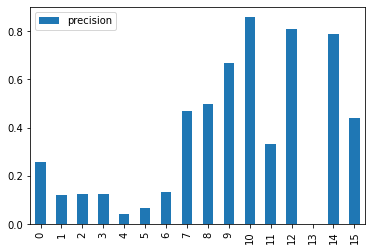

In [39]:
metrics_[['education','precision']].plot.bar()
plt.savefig("../screenshots/precision_ed.png")

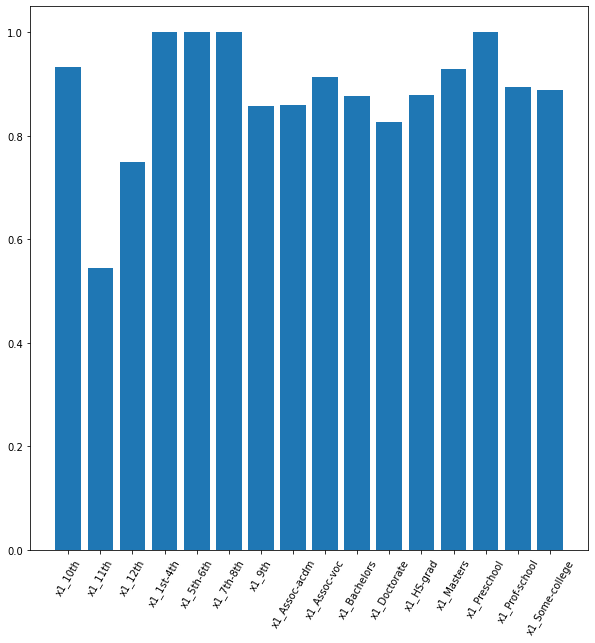

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ed_level = metrics_.education
fbeta = metrics_.recall
plt.bar(ed_level,fbeta)
plt.xticks(rotation=60)
plt.savefig("../screenshots/recall_ed.png",facecolor='w')
plt.show()
